# Predicción de pérdida de potencia en paneles solares mediante el análisis de imágenes.

La presencia de suciedad o defectos en paneles fotovoltaicos supone un problema ya que provoca una reducción en la transformación de energía solar en energía eléctrica. Para entender esto, es necesario conocer el funcionamiento de un panel fotovoltaico. Los paneles fotovoltaicos se basan en el efecto fotoeléctrico para convertir la energía solar en energía eléctrica. El efecto fotoeléctrico se produce cuando una superficie se expone a un tipo de radiación electromagnética. En este momento, la superficie absorbe la luz indicente y emite electrones. En el caso particular de los paneles solares, de la radiación solar se absorbe una partícula llamada fotón que reacciona con los electrones del material de la célula fotovoltaica. Por lo tanto, si se acumula una capa de suciedad sobre la placa, esta reacción no podrá producirse, o lo hará de un modo más reducido.

El objetivo de este proyecto es crear un sistema que nos permita predecir las posibles pérdidas energéticas en paneles fotovoltaicos debidas a la acumulación de suciedad en la superficie del panel fotovoltáico.

Para ello, disponemos de 45754 imágenes de paneles fotovoltaicos con diferentes niveles suciedad, así como paneles que no presentan suciedad. Además, el nombre de cada imagen está formado por la fecha y hora en la que fue tomada, nivel de pérdida de potencia y nivel de irradiancia que incidió sobre la superfie del panel en ese momento.



# 1.0 Preparación de entorno.

En primer lugar, vamos a preparar el entorno de trabajo. Para ello, comenzamos importando las librerías necesarias para abordar el proyecto:

In [ ]:
# Nos aseguramos que usamos TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Comprobamos si está disponible la GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.9.2
TF Hub version: 0.12.0
GPU available


In [ ]:
# Importamos las librerías
from google.colab import drive
import random
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from tensorflow import keras
from pathlib import Path
import os
import csv
import seaborn as sns
import cv2
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Una vez que tenemos todas las librerías importadas, vamos a subir al entorno de colab los datos con los que vamos a trabajar. Las imágenes las tenemos comprimidas en un archivo en Drive, por lo que será necesario conectar Drive con Colab y descomprimir las imágenes en el servidor de Colab para poder trabajar con ellas.

Conectamos Colab con Drive:

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Seguidamente, descomprimimos la carpeta dentro del servidor de Colab:

In [ ]:
!unzip "/content/drive/MyDrive/TFM/SolarPanelSoilingImageDataset.zip" -d "/content/Pictures"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages/solar_Mon_Jun_26_10__2__13_2017_L_0.0826644679236_I_0.537443137255.jpg  
  inflating: /content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages/solar_Tue_Jun_27_11__7__18_2017_L_0.969549921145_I_0.678835294118.jpg  
  inflating: /content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages/solar_Thu_Jun_29_17__54__50_2017_L_0.0777265745008_I_0.0638235294118.jpg  
  inflating: /content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages/solar_Tue_Jun_13_14__0__2_2017_L_0.0543098499139_I_0.239078431373.jpg  
  inflating: /content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages/solar_Mon_Jun_26_11__56__57_2017_L_0.0317435282737_I_0.372964705882.jpg  
  inflating: /content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages/solar_Wed_Jun_21_11__35__24_2017_L_0.00818176714943_I_0.279435294118.jpg  
  inflating: /content/Pictures/Solar

Para familiarizarnos con el tipo de imagen que vamos a usar en el proyecto, graficamos una de ellas usando la librería `Image`, a la que le pasamos la ruta de la imagen:

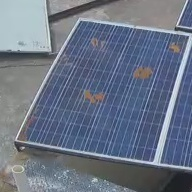

In [ ]:
Image("/content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages/solar_Thu_Jun_15_14__52__2_2017_L_0.413812608822_I_0.443698039216.jpg")

Podemos ver que cada imagen contiene una fotografía de un panel solar, que puede tener suciedad o estar limpio. En este caso, se puede ver que el panel tiene suciedad.

## 1.1 Creación del DataFrame con la información necesaria.

Como se ha comentado previamente, el nombre de cada imagen contiene la fecha y hora en la que fue tomada, además del nivel de pérdida de potencia y el nivel de irradiancia que incidió sobre la superfie en ese momento. Para poder explorar los datos y usarlos posteriormente en la fase de diseño del modelo, vamos a crear un dataframe que contenga toda esta información.

Antes de proceder con la creación del dataframe, vamos a definir una función que extraerá de cada nombre de cada imagen la fecha y hora, el nivel de pérdida de potencia y el nivel de irradiancia. Esta función devolverá un dataframe con toda la información que se ha extraído.

Para ello, la función recibe como parámetro la siguiente información:

* Path: ruta donde se encuentran almacenadas las imágenes.

In [ ]:
def create_dataframe(path):

  """
  
  Función que extraerá de cada nombre de cada imagen la fecha y hora, el nivel de pérdida de potencia y el nivel de irradiancia. 
  Además, esta función devolverá un dataframe con toda la información que se ha extraído.

  Parámetro de entrada: Path (ruta donde se encuentran almacenadas las imágenes).

  """

  # Guardamos en la variable image_dir_path la ruta de las imágenes
  image_dir_path = path
  
  # Creamos una lista donde guardaremos el nombre completo de la imagen
  img_name  = []
  
  # Creamos una lista donde guardaremos el nivel de pérdida de potencia
  img_pot = []
  
  # Creamos una lista donde guardaremos el nivel de irradiancia
  img_irr = []
  
  # Creamos una lista donde guardaremos la fecha y hora en la que se hizo la captura
  img_dat = []
  
  # Creamos un diccionario con los meses del año para transformar la fecha en formato correcto
  month = {
    'Jan' : '01',
    'Feb' : '02',
    'Mar' : '03',
    'Apr' : '04',
    'May' : '05',
    'Jun' : '06',
    'Jul' : '07',
    'Aug' : '08',
    'Sep' : '09',
    'Oct' : '10',
    'Nov' : '11',
    'Dic' : '12'
  }
  
  # Recorremos todas las imágenes para extraer la información necesaria y las añadimos a las listas correspondientes
  for img in os.listdir(image_dir_path):

    # Extraemos el nombre completo de la imagen
    img_name.append(img.split('/')[-1])  

    # Entraemos el valor de irradiancia
    img_irr.append(img.split('/')[-1].split('_')[-1].split('.jpg')[0])

    # Extraemos el nivel de pérdida de potencia
    img_pot.append(img.split('/')[-1].split('_')[-3])

    # Extraemos la fecha y hora de captura de la fotografía. Además, se convierte la fecha en formato AAAA-MM-DD
    img_dat.append(img.split('/')[-1].split('_')[-5] + '-' + month[img.split('/')[-1].split('_')[-12]] + '-' + img.split('/')[-1].split('_')[-11]
                   + ' ' + img.split('/')[-1].split('_')[-10] + ':' + img.split('/')[-1].split('_')[-8] +':' + img.split('/')[-1].split('_')[-6])
    
  
  # Una vez extraída toda la información, creamos el dataframe
  df = pd.DataFrame({'Image Name': img_name,
                     'Date': img_dat,
                     'Power Loss': img_pot,
                     'Irradiance': img_irr},
                    )
  
  # Por último, convertimos los valores Power Loss e Irradiance en formato numérico
  df["Irradiance"] = df.Irradiance.astype(float)
  df["Power Loss"] = df["Power Loss"].astype(float)

  # y los multiplicamos por 100 para representarlos en el rango [0-100]. Además, se redondean a 3 decimales
  df["Power Loss"] = df["Power Loss"]*100
  df["Power Loss"] = df["Power Loss"].round(3)
  df["Irradiance"] = df["Irradiance"]*100
  df["Irradiance"] = df["Irradiance"].round(3)

  # Devolvemos el dataframe creado
  return df

Creamos el dataframe con la información de todas las imágenes del dataset. Para ello, pasamos a la función creada anteriormente la ruta donde se encuentran las imágenes:

In [ ]:
# La variable path_images contiene la ruta donde se encuentran las imágenes
path_images = '/content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages'

# Pasamos la variable path_images como parámetro a la función create_dataframe, que nos devuelve el dataframe creado. Lo guardamos en la variable df
df = create_dataframe(path = path_images)

Observamos las primeras 20 filas del dataframe creado:

In [ ]:
df[:20]

,Image Name,Date,Power Loss,Irradiance
0,solar_Wed_Jun_28_15__5__8_2017_L_0.63868189333...,2017-06-28 15:5:8,63.868,50.994
1,solar_Wed_Jun_28_14__51__46_2017_L_0.633651666...,2017-06-28 14:51:46,63.365,56.750
2,solar_Tue_Jun_13_10__8__23_2017_L_0.0891637528...,2017-06-13 10:8:23,8.916,24.001
3,solar_Sat_Jun_24_12__8__10_2017_L_0.0376098794...,2017-06-24 12:8:10,3.761,29.310
4,solar_Tue_Jun_13_13__58__56_2017_L_0.035134835...,2017-06-13 13:58:56,3.513,74.179
5,solar_Tue_Jun_27_12__20__14_2017_L_0.123475315...,2017-06-27 12:20:14,12.348,77.097
6,solar_Sat_Jun_24_12__30__59_2017_L_0.000236671...,2017-06-24 12:30:59,0.024,81.191
7,solar_Sat_Jun_24_10__33__14_2017_L_0.023776123...,2017-06-24 10:33:14,2.378,54.792
8,solar_Wed_Jun_14_12__11__39_2017_L_0.465037866...,2017-06-14 12:11:39,46.504,67.575
9,solar_Wed_Jun_28_15__39__28_2017_L_0.658349110...,2017-06-28 15:39:28,65.835,24.234


Antes de pasar al análisis de los datos, vamos a comprobar que no nos hayamos dejado alguna imagen en el proceso de crear el dataframe. Para ello, vamos a generar los nombres de los archivos del árbol del directorio donde se encuentran las imágenes descomprimidas, con ayuda del método os.walk() de Python. Con esto, obtendremos el número de imágenes descomprimidas que se encuentran en el directorio y podremos comprobar si tenemos el mismo número de registros en el dataframe.

In [ ]:
# Comprobamos el número de imágenes descomprimidas en el directorio. Este dato se guarda en la variable filename
for dirpath, dirnames, filenames in os.walk("/content/Pictures/Solar_Panel_Soiling_Image_dataset"):
  print(f"Hay {len(dirnames)} directorio y {len(filenames)} imagenes en '{dirpath}'.")

Hay 1 directorio y 1 imagenes en '/content/Pictures/Solar_Panel_Soiling_Image_dataset'.
Hay 0 directorio y 45754 imagenes en '/content/Pictures/Solar_Panel_Soiling_Image_dataset/PanelImages'.


In [ ]:
# Comprobamos si tenemos el mismo número de registros en el dataframe
len(filenames) == len(df)

True

El resultado de la comparación es True, por lo que podemos afirmar que no nos hemos dejado ninguna imagen en el proceso de crear el dataframe.

# 2.0 Análisis de datos.

Una vez creado el dataframe con toda la información necesaria para abordar el proyecto, seguimos con la etapa de análisis de datos.

Primeramente, vemos el tipo de datos de cada variable:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45754 entries, 0 to 45753
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image Name  45754 non-null  object 
 1   Date        45754 non-null  object 
 2   Power Loss  45754 non-null  float64
 3   Irradiance  45754 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.4+ MB


Vemos que la variable Date contiene datos de tipo Object. Vamos a convertirla en formato DateTime. Además, ordenamos el dataframe usando la columna Date, de manera ascendente:

In [ ]:
# Convertimos el tipo de datos de la variable Date a datetime
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True,format='%Y-%d-%m %H:%M:%S')

# Comprobamos
print(df.dtypes)

Image Name            object
Date          datetime64[ns]
Power Loss           float64
Irradiance           float64
dtype: object


In [ ]:
# Y ordenamos el dataset de manera ascendente usando la variable Date
df.sort_values(by='Date', inplace=True)
df

,Image Name,Date,Power Loss,Irradiance
6818,solar_Tue_Jun_13_9__46__49_2017_L_0.0474843723...,2017-06-13 09:46:49,4.748,29.673
35595,solar_Tue_Jun_13_9__46__54_2017_L_0.0273312333...,2017-06-13 09:46:54,2.733,28.883
7705,solar_Tue_Jun_13_9__46__59_2017_L_0.0273312333...,2017-06-13 09:46:59,2.733,28.883
19628,solar_Tue_Jun_13_9__47__4_2017_L_0.03979859380...,2017-06-13 09:47:04,3.980,30.063
4337,solar_Tue_Jun_13_9__47__9_2017_L_0.03979859380...,2017-06-13 09:47:09,3.980,30.063
...,...,...,...,...
23768,solar_Fri_Jun_30_15__53__27_2017_L_0.567408482...,2017-06-30 15:53:27,56.741,24.318
10523,solar_Fri_Jun_30_15__53__32_2017_L_0.567408482...,2017-06-30 15:53:32,56.741,24.318
2043,solar_Fri_Jun_30_15__54__7_2017_L_0.5657411764...,2017-06-30 15:54:07,56.574,29.167
23347,solar_Fri_Jun_30_15__54__12_2017_L_0.565741176...,2017-06-30 15:54:12,56.574,29.167


Vamos a establecer la columna Date como índice del dataframe:

In [ ]:
df = df.set_index('Date')

Por último, comprobamos si existen datos nulos:

In [ ]:
df.isnull().sum()

Image Name    0
Power Loss    0
Irradiance    0
dtype: int64

Vemos que no hay nigún dato nulo.

Una vez analizado el dataframe, continuamos analizando las variables Irradiance y Power Loss.

## 2.1 Variable irradiance.

Vamos a comenzar analizando la serie temporal irradiancia. Para ello, vamos a graficar la evolución de la serie temporal a lo largo del tiempo:


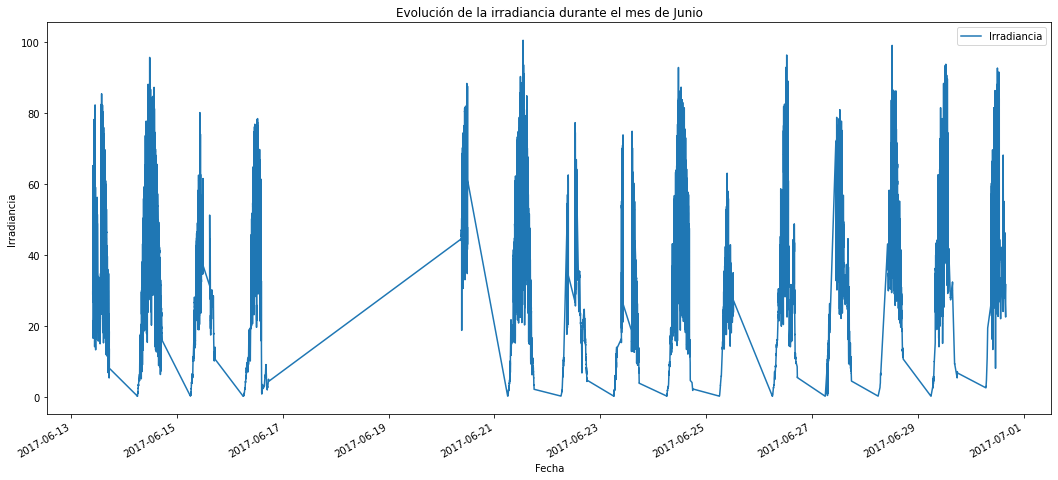

In [ ]:
# Creamos una gráfica de tamaño 18x8
fig, ax = plt.subplots(figsize=(18,8))

# Graficamos la columna Irradiance en la gráfica creada anteriormente
df.Irradiance.plot(ax=ax, label='Irradiancia')

# Agregamos un título a la gráfica
ax.set_title('Evolución de la irradiancia durante el mes de Junio')

# Establecemos una leyenda
ax.legend()

# Establecemos títulos a los ejes
plt.xlabel("Fecha")
plt.ylabel("Irradiancia")

# Mostramos el gráfico
plt.show();


En un primer vistazo, podemos observar que no disponemos de datos para los días 17, 18, 19 y 20 de Junio. Además, se puede observar que la evolución de la irradiancia es similar a lo largo de los días.

Para poder observar con más detalle la evolución de la serie temporal, vamos a graficar la irradiancia para varios días distintos:

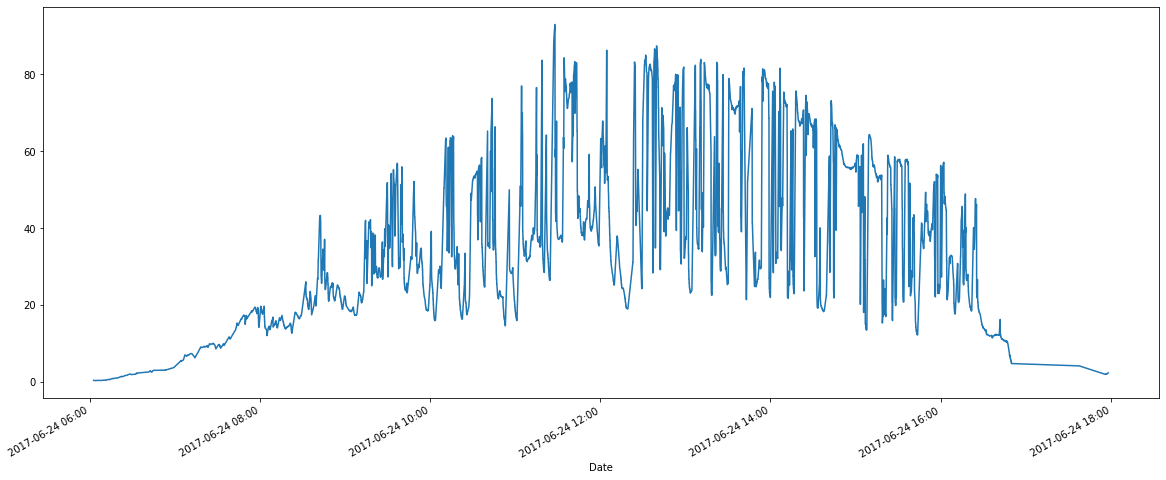

In [ ]:
# Creamos una gráfica de tamaño 20x8
fig, ax = plt.subplots(figsize=(20, 8))

# Seleccionamos un día en concreto, en este caso el día 24
df_day = pd.DataFrame
df_day =df.loc['2017-06-24':'2017-06-25 00:00:00']

# Graficamos la variable irradiance
df_day.Irradiance.plot(ax=ax, label='Irradiancia')

# Adaptamos el formato de fecha
xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(xfmt)

# Graficamos
plt.show()

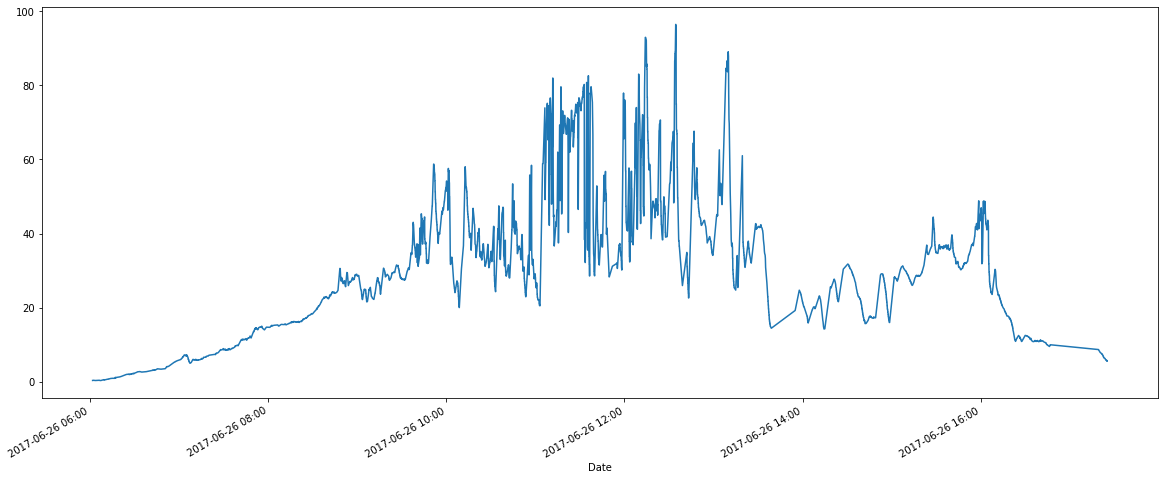

In [ ]:
# Creamos una gráfica de tamaño 20x8
fig, ax = plt.subplots(figsize=(20, 8))

# Seleccionamos un día en concreto, en este caso el día 26
df_day = pd.DataFrame
df_day =df.loc['2017-06-26':'2017-06-27 00:00:00']

# Graficamos la variable irradiance
df_day.Irradiance.plot(ax=ax, label='Irradiancia')

# Adaptamos el formato de fecha
xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(xfmt)

# Graficamos
plt.show()

La irradiancia se define como la energía por unidad de área de radiación solar incidente en una determinada superficie. Analizando las gráficas, se observa que la irradiancia empieza a tener un valor mayor a medida que avanzan las horas del día y empieza a decrecer a medida que el día se va acabando, lo cual tiene sentido teniendo en cuenta la definición de la magnitud irrandiancia.

Vamos a comprobar si existen outliers en nuestros datos de irradiancia. Para ello, vamos a usar la librería `Boxplot`.

[]

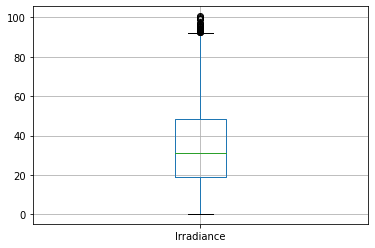

In [ ]:
# Creamos gráfico de cajas
boxplot = df.boxplot(column=['Irradiance'])

# Visualizamos
boxplot.plot()

Analizando el gráfico de caja, se observa que el límite inferior es 0, mientras que el límite superior aproximadamente está entre 90 y 95. Por definición, cualquier punto que esté más allá del límite inferior o superior sería considerado un outlier. En nuestra gráfica de caja vemos varios valores superiores al límite superior. Sin embargo, los valores de irradiancia vienen  dados en el rango [0,100], por lo tanto, solo consideraremos outlier cualquier punto cuyo valor sea superior a 100.

Por otra parte, el segmento que divide la caja en dos partes es la mediana. Esto nos permitirá saber si la distribución es simétrica o asimétrica. Como la mediana no se sitúa en el centro de la caja, la distribución no es simétrica. Además, como la parte más larga de la caja es la parte superior a la mediana, se puede afirmar que la distribución tiene asimetría positiva. Esto quiere decir que los datos se concentran en la parte inferior de la distribución, estando más dispersos en la parte superior.

Vamos a buscar los outliers presentes en en campo Irradiance:. Recordemos que consideraremos outlier cualquier valor superior a 100:

In [ ]:
df.loc[df["Irradiance"] >= 100]

,Image Name,Power Loss,Irradiance
Date,,,
2017-06-21 12:59:53,solar_Wed_Jun_21_12__59__53_2017_L_0.039556837...,3.956,100.030
2017-06-21 12:59:59,solar_Wed_Jun_21_12__59__59_2017_L_0.067040325...,6.704,100.613


Solo hay dos observaciones con valor ligeramente mayor que 100, por lo que no se tomarán medidas correctivas.

## 2.2 Variable Power Loss.

Para comprobar si tenemos datos balanceados, vamos a crear grupos donde agrupar las imágenes cuya pérdida de potencia esté comprendida dentro de un intervalo definido. La agrupación será la siguiente:

* Sin pérdida de potencia en el intervalor [0,5]
* Pérdida de potencia baja en el intervalo [5,10]
* Pérdida de potencia media en el intervalo [10,15]
* Pérdida de potencia alta en el intervalo [15,20]
* Pérdida de potencia extrema en el intervalo [20,100]


Una vez que tenemos definidos los grupos en los que agrupar las imágenes, vamos a crear gráficas para poder visualizarlo. Primeramente, se va a crear una función que recibirá un dataframe con la información de la pérdida de potencia de cada panel de cada imagen en una columna:

In [ ]:
def create_graph(dataframe):

  """

  Función que recibirá un dataframe con la información de la pérdida de potencia de cada panel de cada imagen en una columna y devolverá una gráfica de barras y otra
  gráfica circular.

  """

  # Creamos una columna en el dataframe por cada rango de pérdida de potencia definido previamente. Agrupamos las imágenes que cumplan con los criterios definidos
  dataframe["No Damage"] = [1 if x <=5 else 0 for x in dataframe['Power Loss']]
  dataframe["Low Damage"] = [1 if x > 5 and x <= 10 else 0 for x in dataframe['Power Loss']]
  dataframe["Medium Damage"] = [1 if x > 10 and x <= 15 else 0 for x in dataframe['Power Loss']]
  dataframe["High Damage"] = [1 if x > 15 and x <= 20 else 0 for x in dataframe['Power Loss']]
  dataframe["Extreme Damage"] = [1 if x > 20 else 0 for x in dataframe['Power Loss']]


  # Vamos a crear una columna que resuma la información anterior de tal manera que, para cada imagen, se especifique si pérdida de potencia es nula, baja, media, alta o extrema.  
  # Esto se hace para poder crear gráficas mas visuales.

  # Creamos una columna llamada Damage
  dataframe['Damage']=''

  # Recorremos la columna No Damage y, para cada valor igual a 1, se escribe la frase No Damage en la columna Damage
  dataframe.loc[dataframe["No Damage"]==1,'Damage'] = 'No Damage'

  # Recorremos la columna Low Damage y, para cada valor igual a 1, se escribe la frase Low Damage en la columna Damage
  dataframe.loc[dataframe["Low Damage"]==1,'Damage'] = 'Low'

  # Hacemos lo mismo con el resto de columnas
  dataframe.loc[dataframe["Medium Damage"]==1,'Damage'] = 'Medium'
  dataframe.loc[dataframe["High Damage"]==1,'Damage'] = 'High'
  dataframe.loc[dataframe["Extreme Damage"]==1,'Damage'] = 'Extreme'


  # Ya podemos crear las gráficas. Vamos a graficar 2 figuras, de tamaño 20 x 10
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))
  
  # Elegimos los colores usados en las gráficas
  colors = sns.color_palette('pastel')
  
  # Obtenemos el total de muestras de cada categoría, haciendo uso de la columna Damage
  vc = dataframe["Damage"].value_counts()

  # y las etiquetas de cada categoría
  labels = vc.index
  
  # La primera figura será un gráfico de barras
  p1 = vc.plot(kind="bar", ax=axes[0] ,color=colors, rot = 0)
  
  # Añadimos el valor del número total de muestras de cada categoría sobre el gráfico de barras
  for rect in p1.patches:
    
      # Centramos el valor en cada columna
      y_value = rect.get_height()
      x_value = rect.get_x() + rect.get_width() / 2
      space = 1
      label = "{:.0f}".format(y_value)
      axes[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

  # Establecemos el título de esta gráfica
  axes[0].set_title("Gráfico de barras", fontsize = 16)

  
  # La segunda figura será un gráfico de pastel para ver los porcentajes de cada categoría
  axes[1].pie(vc, labels=labels, autopct='%.2f', startangle=90, explode=tuple([0.1] * len(labels)), colors=colors)

  # Establecemos el título de esta gráfica
  axes[1].set_title("Porcentajes", fontsize = 16)
  
  # Añadimos legenda para la figura y un título general
  plt.legend(fontsize = 12 ,loc='best')
  plt.suptitle("Distribución Damage", fontsize=20)
  plt.show()

Creamos las gráficas pasando por parámetro el dataframe a la función que acabamos de crear:

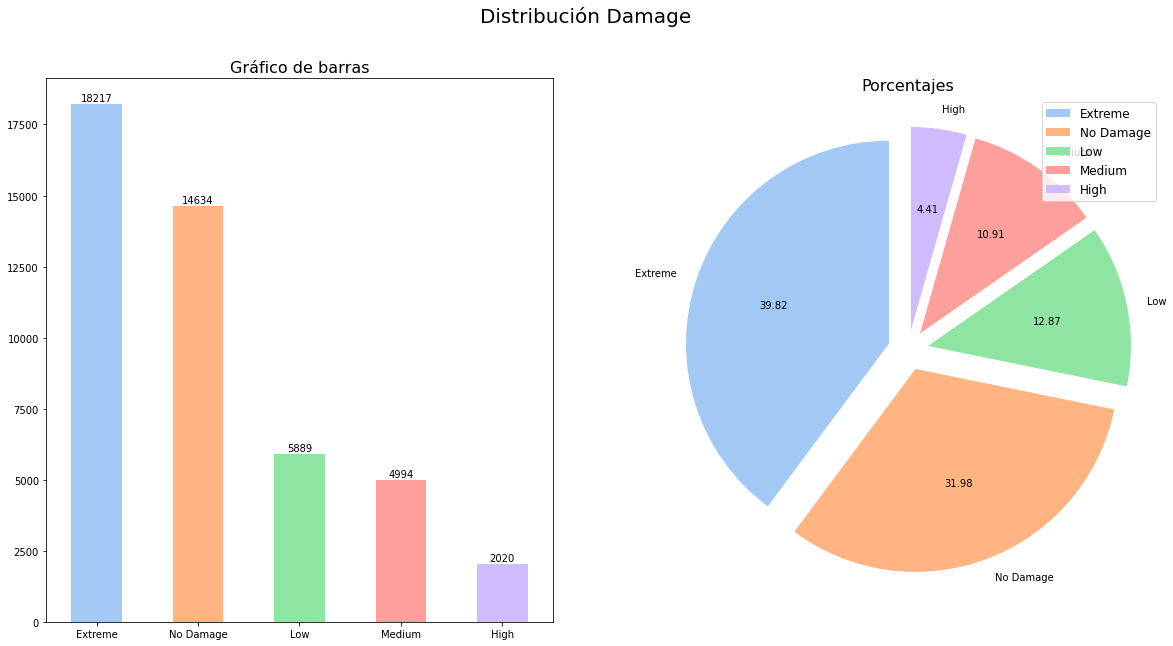

In [ ]:
create_graph(df)

Visualizamos el dataframe para comprobar las columnas creadas con la función anterior:

In [ ]:
df[:20]

,Image Name,Power Loss,Irradiance,No Damage,Low Damage,Medium Damage,High Damage,Extreme Damage,Damage
Date,,,,,,,,,
2017-06-13 09:46:49,solar_Tue_Jun_13_9__46__49_2017_L_0.0474843723...,4.748,29.673,1,0,0,0,0,No Damage
2017-06-13 09:46:54,solar_Tue_Jun_13_9__46__54_2017_L_0.0273312333...,2.733,28.883,1,0,0,0,0,No Damage
2017-06-13 09:46:59,solar_Tue_Jun_13_9__46__59_2017_L_0.0273312333...,2.733,28.883,1,0,0,0,0,No Damage
2017-06-13 09:47:04,solar_Tue_Jun_13_9__47__4_2017_L_0.03979859380...,3.980,30.063,1,0,0,0,0,No Damage
2017-06-13 09:47:09,solar_Tue_Jun_13_9__47__9_2017_L_0.03979859380...,3.980,30.063,1,0,0,0,0,No Damage
2017-06-13 09:47:54,solar_Tue_Jun_13_9__47__54_2017_L_0.0218357907...,2.184,61.385,1,0,0,0,0,No Damage
2017-06-13 09:48:00,solar_Tue_Jun_13_9__48__0_2017_L_0.02183579076...,2.184,61.385,1,0,0,0,0,No Damage
2017-06-13 09:48:10,solar_Tue_Jun_13_9__48__10_2017_L_0.0262653812...,2.627,61.827,1,0,0,0,0,No Damage
2017-06-13 09:48:20,solar_Tue_Jun_13_9__48__20_2017_L_0.1422815570...,14.228,62.097,0,0,1,0,0,Medium


Podemos comprobar que cada imagen se ha categorizado en la categoría correspondiente, de acuerdo con los criterios definidos. Además, se ha creado la columna Daño, resumiendo la información anterior.

Volviendo a las gráficas, comprobamos que los datos no están balanceados, ya que para las categoría Extreme y No Damage tenemos un mayor número de imágenes si lo comparamos con el número de imágenes que tenemos para las categorías Low, Medium y High.

Vamos a comprobar si existen outliers en nuestros datos de pérdida de potencia. Para ello, vamos a usar la librería `Boxplot`.

[]

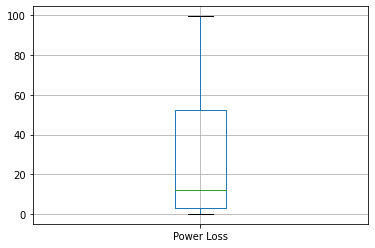

In [ ]:
# Creamos gráfico de barras
boxplot = df.boxplot(column=['Power Loss'])

# Visualizamos
boxplot.plot()

Observando la gráfica anterior puede verse que no hay outliers en nuestros datos de pérdida de potencia.

Por otro lado, como se ha comentado previamente, el segmento que divide la caja en dos partes es la mediana. Debido a que la mediana corta la caja en dos lados desiguales, tenemos distribución asimétrica, es decir, falta de simetría en la distribución con respecto de la media.

Como la parte más larga de la caja es la parte superior a la mediana, tenemos asimetría positiva o segada a la derecha. Esto quiere decir que los datos se concentran en la parte inferior de la distribución, estando más dispersos en la parte superior.


# 3.0 Creación de conjuntos de datos para entrenamiento, validación y test.

Como hemos visto en el análisis previo, disponemos de 45754 imágenes en este proyecto. Para construir un modelo fiable, es fundamental disponer de 3 conjuntos de datos diferenciados:

* Train: es el conjunto de datos que se utiliza para entrenar y hacer que el modelo aprenda las características o patrones ocultos en los datos. En este proyecto se va a destinar para entrenamiento el 80% del total de imágenes.

* Validation: el conjunto de validación es un conjunto de datos, separado del conjunto de entrenamiento, que se utiliza para validar el rendimiento de nuestro modelo durante el entrenamiento. En este proyecto se va a destinar para entrenamiento el 10% del total de imágenes.

* Test: el conjunto de test es un conjunto separado de datos que se utiliza para probar el modelo después de completar el entrenamiento. En este proyecto se va a destinar para entrenamiento el 10% del total de imágenes.


Además, a la hora de dividir los datos, es necesario que esto se haga de manera estratificada.

Para tal fin, nos ayudamos de la librería `split-folders` de Python:

Instalamos la librería:

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


y la importamos:

In [ ]:
import splitfolders

Para crear los 3 conjuntos de datos, usamos la función `splitfolders.ratio`, que acepta los siguientes parámetros:

* Ruta donde se encuentran almacenadas las imágenes a dividir.
* Outuput: carpeta donde se crearán los conjuntos de datos.
* Seed: valor inicial para barajar los elementos. Por defecto es 1337.
* Ratio: porcentaje del total de datos destinados a train, validation y test, en este orden.

In [ ]:
splitfolders.ratio('/content/Pictures/Solar_Panel_Soiling_Image_dataset/', output="output", seed=1337, ratio=(0.8, 0.1,0.1)) 

Copying files: 45754 files [00:12, 3797.89 files/s]


Una vez que tenemos los datos divididos, vamos a comprobar que se hayan creado 3 conjuntos de datos de manera estratificada. 

Empezamos con los datos de train, aunque previamente vamos a crear un dataframe que contenga los datos de las imágenes destinadas a entrenamiento, haciendo uso de la función que definimos anteriormente para crear dataframes. En este caso, le pasamos la ruta donde están almacenadas las imágenes destinadas a entrenamiento:

In [ ]:
# Ruta imágenes
path_imagenes = '/content/output/train/PanelImages'

# Creamos el dataframe
df_train_estratificado = create_dataframe(path = path_imagenes)

# Lo visualizamos
df_train_estratificado

,Image Name,Date,Power Loss,Irradiance
0,solar_Wed_Jun_28_15__5__8_2017_L_0.63868189333...,2017-06-28 15:5:8,63.868,50.994
1,solar_Tue_Jun_13_10__8__23_2017_L_0.0891637528...,2017-06-13 10:8:23,8.916,24.001
2,solar_Tue_Jun_13_13__58__56_2017_L_0.035134835...,2017-06-13 13:58:56,3.513,74.179
3,solar_Tue_Jun_27_12__20__14_2017_L_0.123475315...,2017-06-27 12:20:14,12.348,77.097
4,solar_Sat_Jun_24_12__30__59_2017_L_0.000236671...,2017-06-24 12:30:59,0.024,81.191
...,...,...,...,...
36598,solar_Fri_Jun_16_14__24__15_2017_L_0.408868265...,2017-06-16 14:24:15,40.887,1.521
36599,solar_Wed_Jun_14_14__33__28_2017_L_0.089114790...,2017-06-14 14:33:28,8.911,62.070
36600,solar_Thu_Jun_29_11__37__34_2017_L_0.643142203...,2017-06-29 11:37:34,64.314,51.589
36601,solar_Fri_Jun_23_17__11__22_2017_L_0.291873286...,2017-06-23 17:11:22,29.187,20.166


Vamos a ver la distribución de los datos con ayuda de las gráficas, usando la función que se creó para tal fin. Para ello, pasamos por parámetro el dataframe df_train_estratificado a la función create_dataframe:

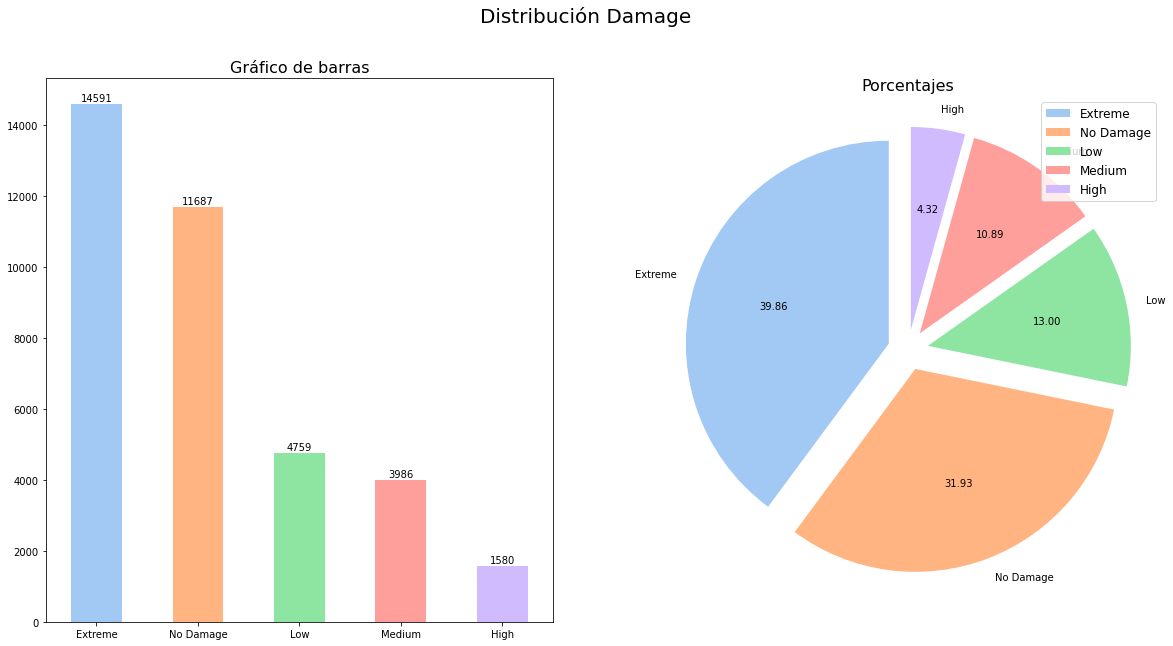

In [ ]:
create_graph(df_train_estratificado)

Continuamos con los datos de validación. En este caso, pasamos a la función create_datafreame la ruta donde están almacenadas las imágenes destinadas a validación:

In [ ]:
# Ruta imágenes
path_imagenes = '/content/output/val/PanelImages'

# Creamos el dataframe
df_val_estratificado = create_dataframe(path = path_imagenes)

# Lo visualizamos
df_val_estratificado

,Image Name,Date,Power Loss,Irradiance
0,solar_Wed_Jun_28_14__51__46_2017_L_0.633651666...,2017-06-28 14:51:46,63.365,56.750
1,solar_Fri_Jun_30_15__31__2_2017_L_0.5362695661...,2017-06-30 15:31:2,53.627,44.795
2,solar_Wed_Jun_14_10__3__43_2017_L_0.2079107289...,2017-06-14 10:3:43,20.791,73.695
3,solar_Tue_Jun_13_13__25__35_2017_L_0.074575962...,2017-06-13 13:25:35,7.458,30.126
4,solar_Thu_Jun_15_8__45__23_2017_L_0.0853427016...,2017-06-15 8:45:23,8.534,40.074
...,...,...,...,...
4570,solar_Fri_Jun_23_14__12__36_2017_L_0.842175681...,2017-06-23 14:12:36,84.218,14.362
4571,solar_Tue_Jun_13_17__14__42_2017_L_0.104382136...,2017-06-13 17:14:42,10.438,6.560
4572,solar_Fri_Jun_23_7__24__55_2017_L_0.5419713667...,2017-06-23 7:24:55,54.197,11.422
4573,solar_Tue_Jun_20_10__50__32_2017_L_0.122609645...,2017-06-20 10:50:32,12.261,76.861


y vemos la distribución de los datos con ayuda de las gráficas:

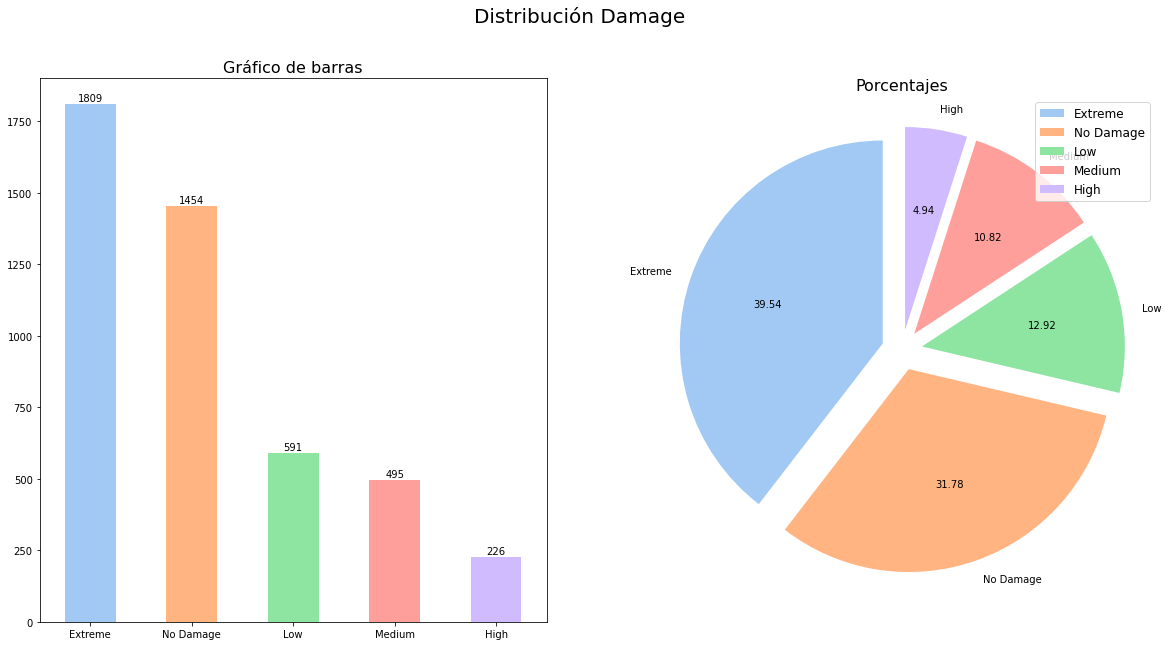

In [ ]:
create_graph(df_val_estratificado)

Por último, acabamos con los datos de test:

In [ ]:
# Ruta imágenes
path_imagenes = '/content/output/test/PanelImages'

# Creamos el dataframe
df_test_estratificado = create_dataframe(path = path_imagenes)

# Lo visualizamos
df_test_estratificado

,Image Name,Date,Power Loss,Irradiance
0,solar_Sat_Jun_24_12__8__10_2017_L_0.0376098794...,2017-06-24 12:8:10,3.761,29.310
1,solar_Wed_Jun_28_15__39__28_2017_L_0.658349110...,2017-06-28 15:39:28,65.835,24.234
2,solar_Wed_Jun_14_16__19__46_2017_L_0.132167315...,2017-06-14 16:19:46,13.217,35.045
3,solar_Sat_Jun_24_13__49__50_2017_L_0.019513431...,2017-06-24 13:49:50,1.951,24.759
4,solar_Wed_Jun_28_11__45__39_2017_L_0.637964271...,2017-06-28 11:45:39,63.796,39.668
...,...,...,...,...
4571,solar_Fri_Jun_23_17__28__54_2017_L_0.348912830...,2017-06-23 17:28:54,34.891,10.010
4572,solar_Wed_Jun_28_16__52__31_2017_L_0.656709615...,2017-06-28 16:52:31,65.671,18.931
4573,solar_Wed_Jun_21_9__44__2_2017_L_0.78697996241...,2017-06-21 9:44:2,78.698,44.661
4574,solar_Wed_Jun_28_14__58__4_2017_L_0.6654717030...,2017-06-28 14:58:4,66.547,29.755


La distribución de los datos de test es:

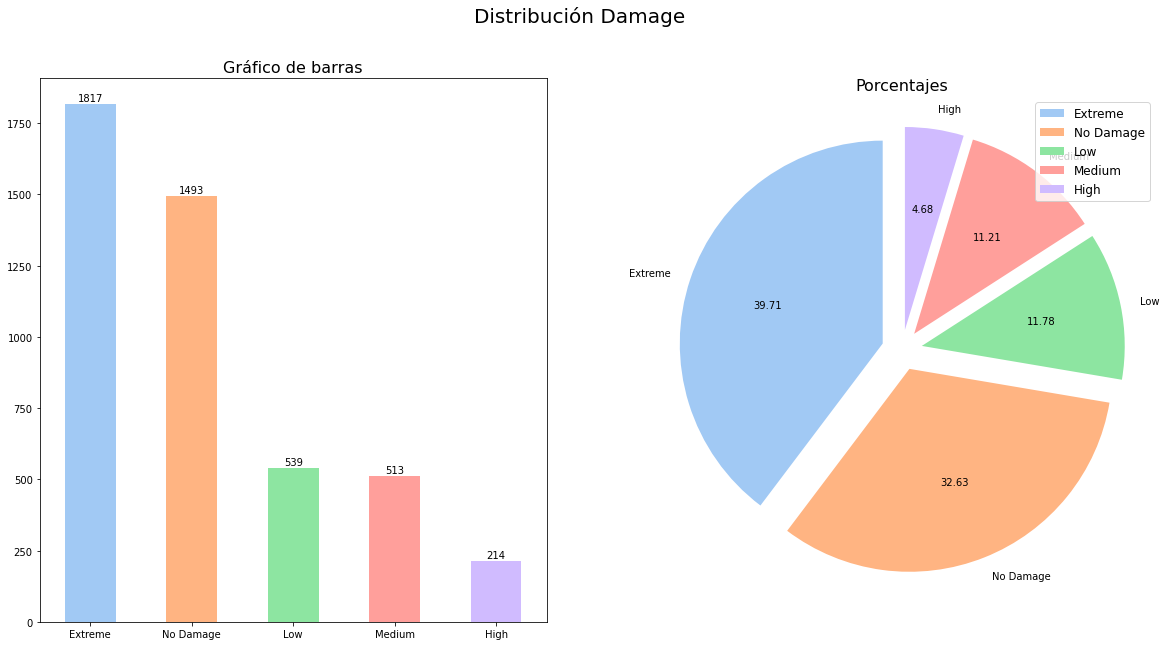

In [ ]:
create_graph(df_test_estratificado)

Observando las gráficas, podemos notar que para entrenamiento, validación y test tenemos dividos los datos de manera estratificada, ya que se mantienen las proporciones entre las distintas categorías de nivel de daño.

# 4.0 MODELADO.

En este proyecto vamos a usar dos redes neuronales diferentes. 

La primera, será una red neuronal convolucional no demasiado compleja que vamos a construir con ayuda del siguiente artículo publicado en https://link.springer.com/content/pdf/10.1007/s10489-022-04146-3.pdf, cuyos autores son Diego Marin Santos, Manuel E. Gegundez-Arias, Juan A. Contreras Fernandez, Isaac Perez Borrero y Hector Pallares Manrique.

La segunda red neuronal será la conocida red neuronal convolucional VGG16.

### 4.1 CNN propuesta

La red neuronal propuesta está formada por 6 bloques con estructura similar. En cada bloque se hacen las siguientes operaciones:

* Convolución: se realiza una operación de convolución al tensor de entrada, con un kernel de tamaño 3x3, stride de tamaño 1 y padding de 1.
* Normalización de Batch: se aplica para acelerar y facilitar la convergencia en el entrenamiento.
* ReLU: se aplica a la salida de la normalización del batch.

La única diferencia entre cada bloque radica en el número de capas de convolución incluidas, que progresivamente aumentan de 32 a 96. 

Además, al final de los primeros 5 bloques, se incluye una capa de pooling para reducir el tamaño de datos generados. Para ello, se realiza una operación de MaxPooling de tamañano 3x3, stride de 2 y padding de 1. 

Por el contrario, al final del último bloque, se aplica una operación de GlobalAveragePooling. Además, en este bloque final se añaden dos capas densas, una con 20 neuronas y función de activación relu, y la capa densa final que tendrá una neurona y función de activación relu. Esta última capa está destinada a dar la predicción de pérdida de potencia.

Empezamos creando el modelo:

In [ ]:
model = tf.keras.Sequential(
    [

    # BLOQUE 1  

		tf.keras.layers.Conv2D(input_shape=(192, 192, 3), kernel_size=(3, 3), padding='same', strides = 1, filters = 32),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2),

    # BLOQUE 2 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 48),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2),    

    # BLOQUE 3 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 56),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2), 

    # BLOQUE 4 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 64),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2), 


    # BLOQUE 5 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 64),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.MaxPooling2D(pool_size = (3, 3), padding='same', strides = 2),     

    # BLOQUE 6 

    tf.keras.layers.Conv2D(kernel_size=(3, 3), padding='same', strides = 1, filters = 96),
	  tf.keras.layers.BatchNormalization(),
	  tf.keras.layers.ReLU(),
	  tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(20,activation='relu'),  
		tf.keras.layers.Dense(1,activation='relu')
    ]
)


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 192, 192, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 48)        13872     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 48)       1

Una vez que tenemos el modelo creado, pasamos a definir el código para definir y probar la función de pérdida. Al tratarse de un problema de regresión, elegimos la métrica MeanAbsoluteError. Esta métrica calcula la diferencia media entre los valores calculados y los valores reales.

In [ ]:
loss_fn = tf.keras.losses.MeanAbsoluteError()

A continuación, pasamos a  definir las métricas de evaluación. Como optimizador, vamos a elegir Adam, mientras que para calcular las pérdidas, elegimos la métrica MeanAbsoluteError.

In [ ]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['MeanAbsoluteError']
)

Seguidamente, definimos el hiperparámetro Batch_Size, que define el número de muestras que se propagarán a través de la red. Elegimos un BATCH_SIZE igual a 32.

In [ ]:
BATCH_SIZE = 32

Una vez que tenemos definido el modelo, las métricas de evaluación, la función de pérdidas e hiperparámetro, pasamos a detallar como se alimentará la red con los datos de los que disponemos.
Para tal fin, vamos a usar un generador de imagenes. Esta técnica permite preprocesar los datos de forma personalizada para cada bucle de entrenamiento, como por ejemplo usando técnicas de aumento de datos, aunque la técnica de aumento de datos se usará posteriormente. Otra ventaja de usar un generador de imágenes es que permite usar gradualmente el conjunto de datos de entrenamiento si su tamaño no permite cargar todo en la RAM.

Definimos un generador de imágenes para el conjunto de datos de train, otro para validation y otro para test. Para ello, usamos la función de keras `ImageDataGenerator`. Como hemos comentado previamente, las técnicas de aumento de datos no se usarán de momento, por lo que solo vamos a reescalar los datos. El objetivo de reescalar los datos radica en que nuestras imágenes originales consisten en coeficientes RGB en el rango [0,255], pero tales valores son demasiado altos para que nuestro modelo los procese, por lo que vamos a reescalar para que los valores de los coeficientes RGB estén en el rango [0,1].

In [ ]:
# Generador datos entrenamiento
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# Generador datos validación
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Generador datos test
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

Además, es necesario definir el directorio donde están las imágenes. Para el caso de las imágenes destinadas a entrenamiento, el directorio será `/content/output/train/PanelImages/`. Para las imágenes destinadas a validación, el directorio será `/content/output/val/PanelImages/`, mientras que para las imágenes destinadas a test, el directorio será `/content/output/test/PanelImages/`.

Por otro lado, como usaremos el generador para alimentar a la red, nos ayudaremos del dataframe creado para especificar el valor de la variable X, que será el nombre de la imagen dentro del directorio, y el valor Y que se pretende predicir, que será la pérdida de potencia de esa imagen en concreto.

In [ ]:
# Alimentamos el generador de imágenes con datos de entrenamiento
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train_estratificado,
    directory='/content/output/train/PanelImages/',
    x_col='Image Name',
    y_col='Power Loss',
    target_size=(192, 192),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42
)

# Alimentamos el generador de imágenes con datos de validación
val_images = val_generator.flow_from_dataframe(
    dataframe=df_val_estratificado,
    directory='/content/output/val/PanelImages/',
    x_col='Image Name',
    y_col='Power Loss',
    target_size=(192, 192),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42
)

# Alimentamos el generador de imágenes con datos de test
test_images = test_generator.flow_from_dataframe(  
    dataframe=df_test_estratificado,
    directory='/content/output/test/PanelImages/',
    x_col='Image Name',
    y_col='Power Loss',
    class_mode="raw",
    shuffle=False,
    target_size=(192, 192),  # size of the image
    batch_size=1,  # use only one image for visualization
)

Found 36603 validated image filenames.
Found 4575 validated image filenames.
Found 4576 validated image filenames.


Para comprobar el correcto funcionamiento del generador, vamos a graficar 15 imágenes aleatorias del conjunto destinado a entrenamiento, junto con sus valores reales de pérdida de potencia:

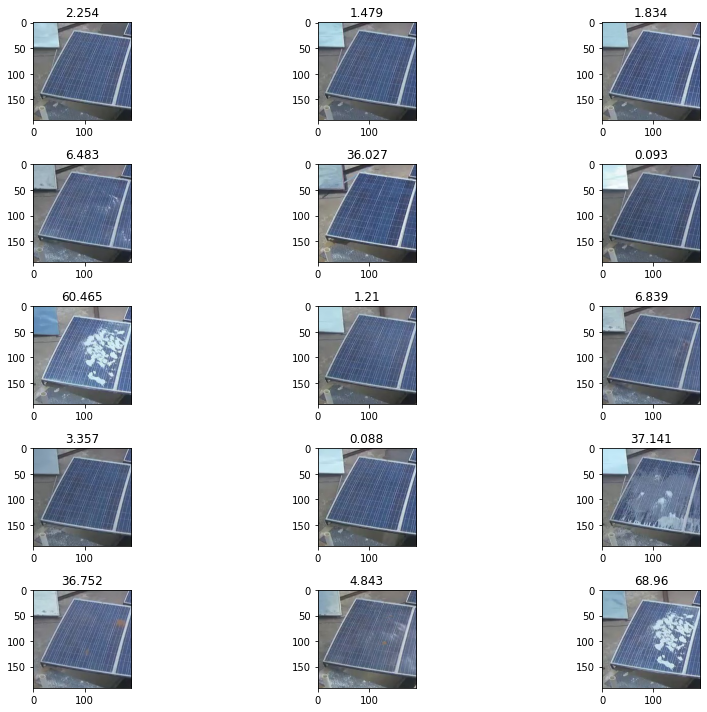

In [ ]:
# Número de filas
num_rows = 5

# Número de columnas
num_cols = 3

# Definimos el tamaño de la figura en función del número de columnas y filas
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(15):

    # Creamos la ventana de graficación
    plt.subplot(num_rows, 2*num_cols, 2*i+1)

    # Generamos un batch de imágenes de train. Nos quedamos con la ruta a dicha imagen y el valor de pérdida de potencia
    batch,labels = next(train_images)

    # Graficamos la imagen junto con el valor de pérdida de potencia
    img = batch[0]
    
    # Añadimos el valor de pérdida de potencia como título
    plt.title(labels[0])
    plt.imshow(img)
    
plt.tight_layout()
plt.show()

Una vez comprobado el correcto funcionamiento del generador de imágenes, estamos en disposición de empezar con el entrenamiento. 

El entrenamiento se ha llevado a cabo de la siguiente manera. Debido a las limitaciones de uso de una GPU en versiones gratuitas de colab, no es posible entrenar durante más de 5 horas. Para salvar este impedimento, hemos dividido el entrenamiento en varias fases, de manera que en cada fase hemos usado un número de épocas tal que el tiempo de entrenamiento total no superase las 4 horas. Cuando el modelo había acabado con el entrenamiento en un fase, procedíamos a guardar la red y los valores de pérdidas en un fichero CSV. El objetivo de guardar la red es para poder seguir entrenandola en la siguiente fase de entrenamiento con los pesos que se obtuvieron en la fase presente, mientras que el objetivo de guardar los valores de pérdidas en el fichero CSV es para poder graficar en una única gráfica dichos valores a lo largo del número total de épocas usadas en el entrenamiento.

Esta metodología se ha usado tanto para la CNN propuesta como para la VGG16.

### 4.1.1 CNN propuesta: entrenamiento fase 1.



Antes de empezar con el entrenamiento, vamos a definir un método llamado Callbacks. Este método de Keras puede ejecutar acciones durante la fase de entrenamiento. Vamos a definir varias acciones en este proyecto.

En primer lugar, definimos una función que nos guardará el modelo que menor valor de pérdida consiga durante el entrenamiento. Para ello, usaremos la librería `ModelCheckPoint` de Keras. Con el uso del parámetro filepath, podemos establecer como queremos que se nombre el modelo guardado.Para una mayor claridad, haremos que el modelo se guarde con la época y el valor de pérdidas.

In [ ]:
# Establecemos el nombre del modelo guardado
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

# Creamos una instancia de ModelCheckPoint, eligiendo que solo se guarde el mejor modelo
best_model = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

Además, vamos a definir una función que pare el entrenamiento si el modelo no ha mejorado el valor de pérdidas a lo largo de 50 épocas. Para ello, usamos `EarlyStopping`:

In [ ]:
earlystop = EarlyStopping(patience=50)

También, vamos a definir una función que reduzca el valor de learning rate en un factor de 0.5, si el modelo no ha mejorado el valor de pérdidas a lo largo de 10 épocas. Para ello, usamos `ReduceLROnPlateau`:

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='mean_absolute_error', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

Estas 3 funciones componen el método de Callback que se usará durante el entrenamiento. Lo guardamos en la variable callbacks.

In [ ]:
callbacks = [earlystop, best_model, learning_rate_reduction]

Ya podemos empezar a entrenar el modelo. Para ello, usaremos el método .fit() de Keras. Especificamos los datos de entrenamiento, que serán alimentados con el generador de imágenes de entrenamiento, el tamaño del batch, el número de épocas, elegimos que los datos se barajen, le indicamos que se debe usar el método de callback previamente definido y, por último, especificamos las imágenes que se usarán para ir validando como de bien se comporta el modelo con datos nuevos que no han sido usados en el entrenamiento.

Los resultados obtenidos durante el entrenamiento se guardarán en la variable history.

In [ ]:
history = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 80, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/80
1144/1144 [==============================] - ETA: 0s - loss: 7.8995 - mean_absolute_error: 7.8995
Epoch 1: val_loss improved from inf to 6.05185, saving model to my_best_model.epoch01-loss6.05.hdf5
1144/1144 [==============================] - 80s 70ms/step - loss: 7.8995 - mean_absolute_error: 7.8995 - val_loss: 6.0518 - val_mean_absolute_error: 6.0518 - lr: 0.0010
Epoch 2/80
1144/1144 [==============================] - ETA: 0s - loss: 5.8103 - mean_absolute_error: 5.8103
Epoch 2: val_loss improved from 6.05185 to 5.22504, saving model to my_best_model.epoch02-loss5.23.hdf5
1144/1144 [==============================] - 76s 67ms/step - loss: 5.8103 - mean_absolute_error: 5.8103 - val_loss: 5.2250 - val_mean_absolute_error: 5.2250 - lr: 0.0010
Epoch 3/80
1144/1144 [==============================] - ETA: 0s - loss: 5.1931 - mean_absolute_error: 5.1931
Epoch 3: val_loss did not improve from 5.22504
1144/1144 [==============================] - 78s 68ms/step - loss: 5.1931 - mean_a

Hemos acabado con la fase 1 de entrenamiento. Vamos a graficar los resultados de las pérdidas durante entrenamiento y validación.

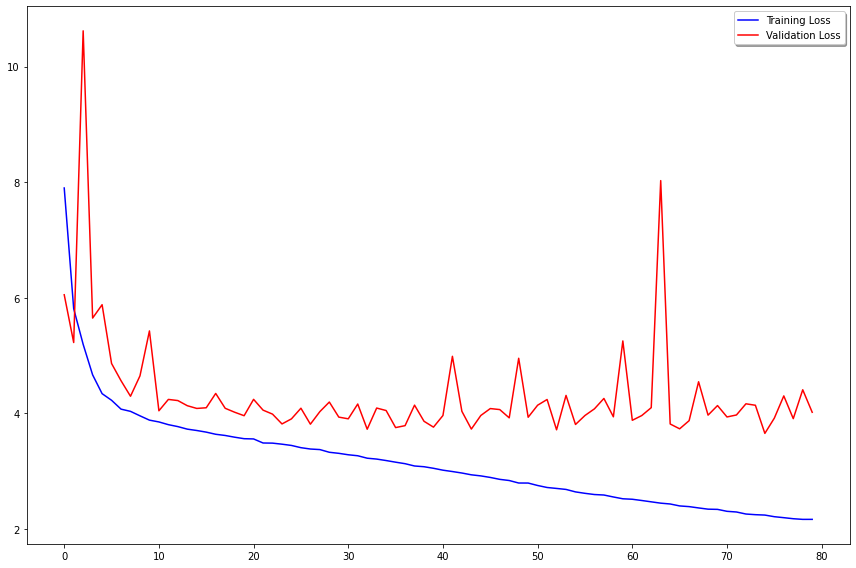

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento. Recordemos que se eligió la métrica MeanAbsoluteError
ax1.plot(history.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 8. Con el paso de las épocas, este valor disminuye y al final del entrenamiento de esta fase se sitúa en torno a 2.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 6. A lo largo del entrenamiento, este valor se va reduciendo y durante las últimas épocas vemos que se sitúa en torno a 4.3. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 75, con un valor de pérdidas de 3.65.

Guardamos estos resultados para no perderlos y poder graficarlo todo en conjunto al final de todas las fases de las que se componga el entrenamiento.

In [ ]:
# Convertimos el diccionario history.history en dataframe  
hist_df = pd.DataFrame(history.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.2 CNN propuesta: entrenamiento fase 2.

Empezamos importando el modelo guardado durante la fase anterior.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch75-loss3.65.hdf5")

Seguimos entrenando el modelo durante 80 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 80, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/80
1144/1144 [==============================] - ETA: 0s - loss: 2.5119 - mean_absolute_error: 2.5119
Epoch 1: val_loss improved from inf to 3.82129, saving model to my_best_model.epoch01-loss3.82.hdf5
1144/1144 [==============================] - 87s 68ms/step - loss: 2.5119 - mean_absolute_error: 2.5119 - val_loss: 3.8213 - val_mean_absolute_error: 3.8213 - lr: 0.0010
Epoch 2/80
1144/1144 [==============================] - ETA: 0s - loss: 2.4446 - mean_absolute_error: 2.4446
Epoch 2: val_loss improved from 3.82129 to 3.81327, saving model to my_best_model.epoch02-loss3.81.hdf5
1144/1144 [==============================] - 76s 66ms/step - loss: 2.4446 - mean_absolute_error: 2.4446 - val_loss: 3.8133 - val_mean_absolute_error: 3.8133 - lr: 0.0010
Epoch 3/80
1144/1144 [==============================] - ETA: 0s - loss: 2.3991 - mean_absolute_error: 2.3991
Epoch 3: val_loss did not improve from 3.81327
1144/1144 [==============================] - 78s 68ms/step - loss: 2.3991 - mean_a

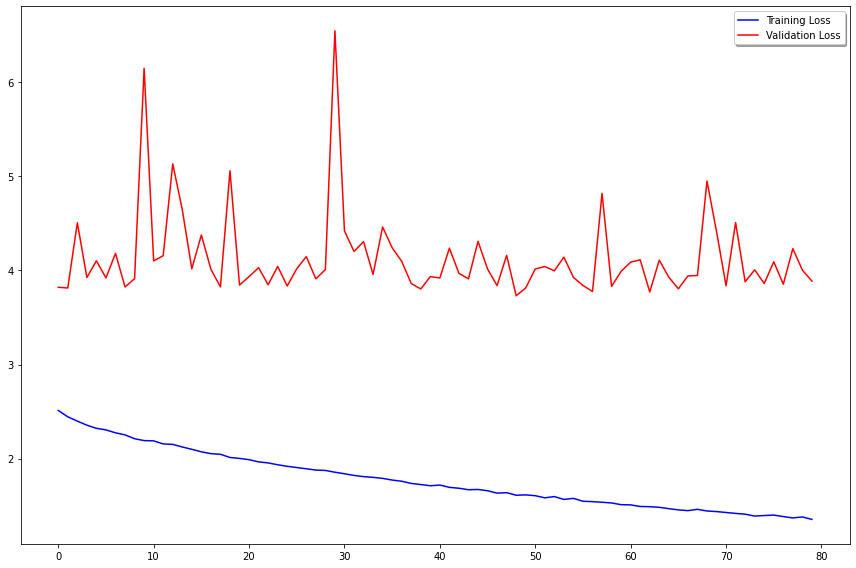

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(history.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, sigue disminuyendo el valor de pérdidas. Con el paso de las épocas, vemos que al final del entrenamiento se sitúa en torno a 1.3.

Durante la fase de validación, vemos que el modelo continúa aprendiendo, ya que el valor de pérdidas parece ir estabilizándose con el paso de las épocas. Durante varias épocas, vemos que el valor de pérdida se sitúa por debajo de 4, en torno a 3.7. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 49, con un valor de pérdidas de 3.73. 

Observando ambas curvas, vemos que durante la fase de entrenamiento el ritmo de aprendizaje es bastante mayor que durante la fase de validación. Esto podría indicar que el modelo está empezando a sobreaprender los datos en fase de entrenamiento. Vamos a seguir entrenando el modelo durante 80 épocas más para ver si conseguimos alguna mejora en validacion.

In [ ]:
# Convertimos el diccionario history.history en dataframe  
hist_df = pd.DataFrame(history.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.3 CNN propuesta: entrenamiento fase 3.

Empezamos importando el modelo guardado durante la fase anterior.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch49-loss3.73.hdf5")

Seguimos entrenando el modelo durante 80 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 80, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/80
1144/1144 [==============================] - ETA: 0s - loss: 2.4948 - mean_absolute_error: 2.4948
Epoch 1: val_loss did not improve from 3.73107
1144/1144 [==============================] - 80s 69ms/step - loss: 2.4948 - mean_absolute_error: 2.4948 - val_loss: 3.9071 - val_mean_absolute_error: 3.9071 - lr: 0.0010
Epoch 2/80
1144/1144 [==============================] - ETA: 0s - loss: 2.4465 - mean_absolute_error: 2.4465
Epoch 2: val_loss did not improve from 3.73107
1144/1144 [==============================] - 75s 65ms/step - loss: 2.4465 - mean_absolute_error: 2.4465 - val_loss: 3.8078 - val_mean_absolute_error: 3.8078 - lr: 0.0010
Epoch 3/80
1144/1144 [==============================] - ETA: 0s - loss: 2.4039 - mean_absolute_error: 2.4039
Epoch 3: val_loss did not improve from 3.73107
1144/1144 [==============================] - 74s 65ms/step - loss: 2.4039 - mean_absolute_error: 2.4039 - val_loss: 3.8873 - val_mean_absolute_error: 3.8873 - lr: 0.0010
Epoch 4/80
1144/1144 [

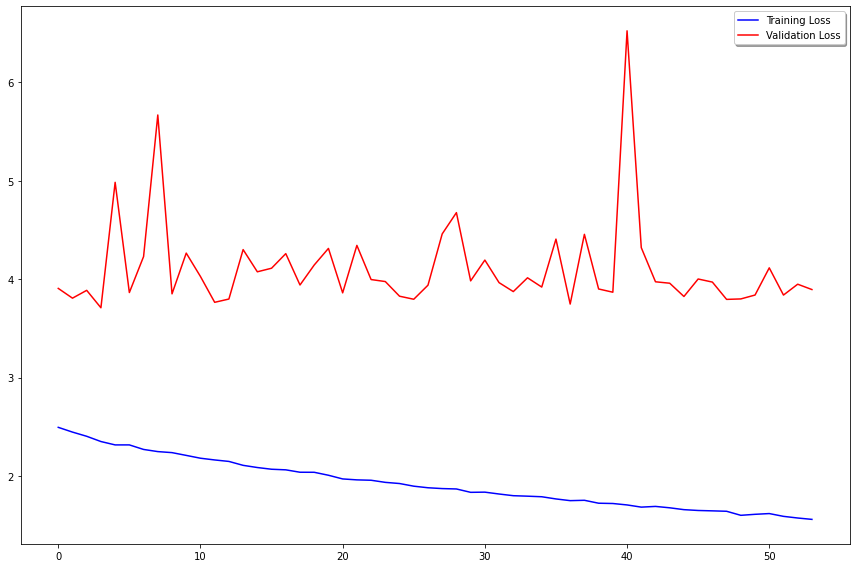

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(history.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos comprobar que no se ha entrenado el modelo durante las 80 épocas, ya que no se ha mejorado desde la época 4 de esta fase.

Durante la fase de entrenamiento, vemos que el valor de péridas empieza en 2.49 y termina en 1.55. Estos valores son peores que los conseguidos en la época anterior.

Durante la fase de validación, vemos que el modelo apenas mejora el resultado de la fase anterior. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 4, con un valor de pérdidas de 3.71.

Comprobamos que el modelo no ha mejorado el valor de pérdidas conseguido en la fase 1 de entrenamiento durante las 2 fases posteriores. Esto parece indicar que el modelo no es capaz de extraer más información de los datos, por lo que dejamos de entrenar este modelo.

In [ ]:
# Convertimos el diccionario history.history en dataframe  
hist_df = pd.DataFrame(history.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.4 CNN propuesta: análisis de resultados.

Una vez acabado el entrenamiento del primer modelo, vamos a graficar los resultados obtenidos durante las 240 épocas que ha durado el entrenamiento.

Importamos los CSV guardados:

In [ ]:
history1 = pd.read_csv("/content/drive/MyDrive/TFM/history1.csv")
history2 = pd.read_csv("/content/drive/MyDrive/TFM/history2.csv")
history3 = pd.read_csv("/content/drive/MyDrive/TFM/history3.csv")

Agrupamos los resultados en un único dataframe:

In [ ]:
final_dataframe = pd.concat([history1, history2, history3]).reset_index(drop=True) 

Y graficamos los valores de pérdidas:

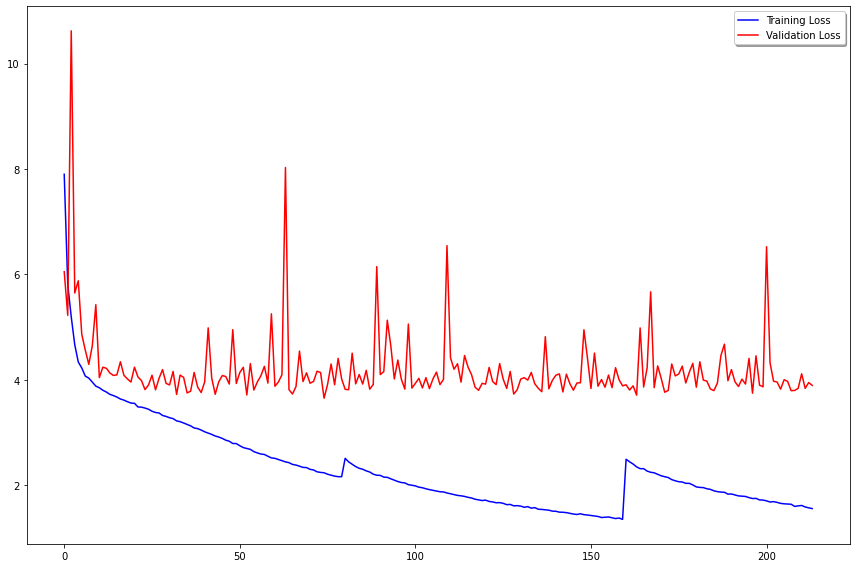

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(final_dataframe['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(final_dataframe['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Observando la curva de pérdidas durante la etapa de validación, vemos que durante las distintas épocas el valor de pérdida mayoritariamente oscila entre 3.7 y 4.5, aproximadamente. Esto nos hace pensar que el modelo no va a mejorar en validación aunque sigamos entrenando durante mas épocas. Por otra parte, vemos que el valor de pérdidas durante la etapa de entrenamiento va disminuyendo durante el paso de las épocas a pesar de que en validación no parece mejorar significativamente, por que lo parece que el modelo está sobreaprendiendo los datos de entrenamiento.



Vamos a pasar a evaluar el modelo y a hacer predicciones sobre los datos de test. Para ello, importamos el modelo que menor valor de pérdias ha conseguido. Recordemos que el mejor modelo se consiguió en la fase 1 de entrenamiento, con un valor de pérdidas en validación de 3.65.

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch75-loss3.65.hdf5")

Evaluamos:

In [ ]:
model.evaluate(test_images)

4576/4576 [==============================] - 33s 5ms/step - loss: 3.7298 - mean_absolute_error: 3.7298


[3.729844808578491, 3.729844808578491]

Hacemos predicciones:

In [ ]:
predictions = model.predict(test_images)

4576/4576 [==============================] - 21s 5ms/step


Las guardamos en un dataframe:

In [ ]:
df_predictions = pd.DataFrame(data = predictions, columns = ['Predictions'])

Y graficamos 15 imágenes aleatorias junto con los valores de pérdida de potencia predichos y los valores de pérdida de potencia reales:

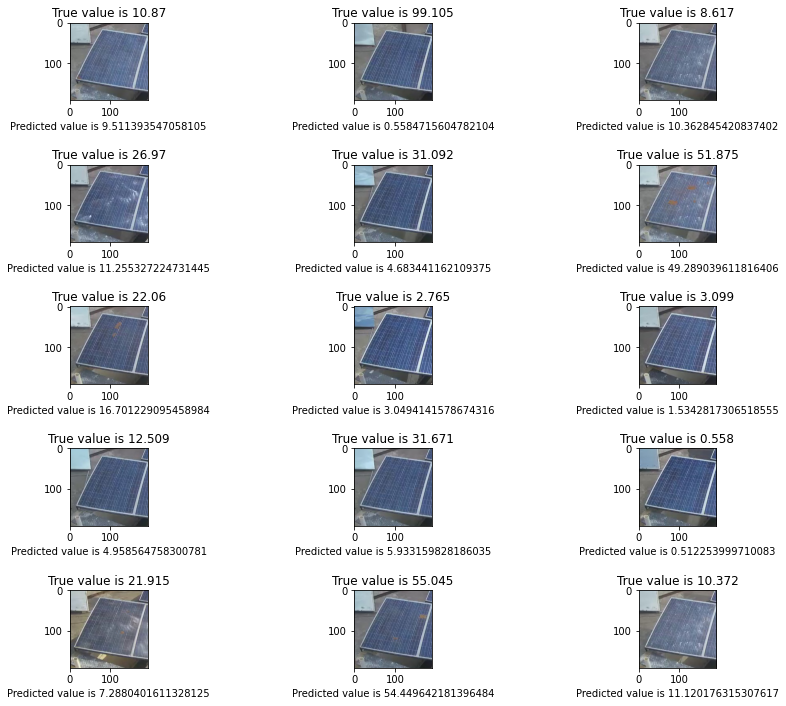

In [ ]:
# Número de filas
num_rows = 5

# Número de columnas
num_cols = 3

len(df_test_estratificado)

num_images = num_rows*num_cols
# Definimos el tamaño de la figura en función del número de columnas y filas
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):

  # Creamos la ventana de graficación
  plt.subplot(num_rows, 2*num_cols, 2*i+1)

  # Elegimos una imagen aleatoria
  sample = random.choice(range(len(df_test_estratificado)))
  
  # Graficamos la imagen elegida
  image = plt.imread('/content/output/test/PanelImages/' + df_test_estratificado['Image Name'][sample])
  plt.imshow(image, cmap=plt.cm.binary)

  # Añadimos el valor real y la predicción de pérdida de potencia
  plt.title('True value is {}'.format(df_test_estratificado['Power Loss'][sample]))
  plt.xlabel('Predicted value is {}'.format(df_predictions['Predictions'][sample]))

plt.tight_layout()
plt.show()

Analizando las predicciones vemos que, para la mitad de las imágenes, el valor predicho es cercano al valor real. Sin embargo, también se puede observar que hay valores predichos que se alejan bastante del valor verdadero.

Por último, vamos a comprobar como se comporta el modelo con imágenes de paneles solares diferentes a las usadas hasta ahora.

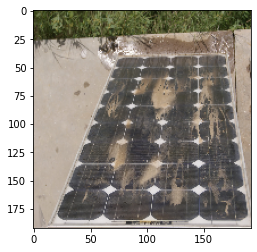

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/1.jpg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 7s 7s/step


array([[44.38069]], dtype=float32)

Vemos que la red da una predicción de pérdida de potencia del 44.3%. Desconocemos el valor real de pérdida de potencia de este panel de la imagen, por lo que no podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.

Comprobamos con otra imagen.

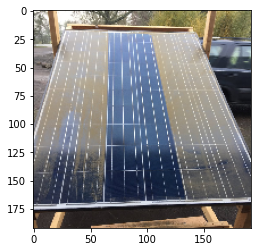

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/2.jpeg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 17ms/step


array([[52.26561]], dtype=float32)

Nuevamente, desconocemos el valor real de pérdida de potencia de este panel de la imagen. Vemos que la red da una predicción de pérdida de potencia del 52.26%.No podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.

Por último, vamos a introducir una imagen de un panel que, aparentemente, no deberia presentar pérdida de potencia debido a suciedad presente en el panel.

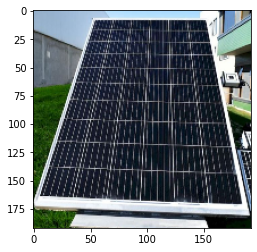

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/5.JPG')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 71ms/step


array([[34.939587]], dtype=float32)

Vemos que la red da una predicción de pérdida de potencia del 34.93%. Aunque desconocemos el valor real de pérdida de potencia, no parece que este panel deba tener un valor alto. Por lo tanto, en este caso, todo parece indicar que la red está dando un valor de pérdida de potencia erróneo.

### 4.2 VGG16 - Transfer Learning

La siguiente red neuronal convolucional que se va a usar en nuestro proyecto es la conocida VGG16. Es una red con arquitectura simple y, en cierto modo, parecida a nuestra red neuronal convolucional propuesta.

La VGG16 está formada por bloques compuestos por un número incremental de capas convolucionales con filtros de tamaño 3×3. Además, se añaden capas de maxpooling entre las capas convolucionales para reducir el tamaño de los datos generados. Finalmente, se utiliza un bloque de clasificación compuesto por dos capas densas de 4096 neuronas cada una, y una última capa, que es la de salida, de 1000 neuronas.

En nuestro proyecto, vamos a usar la técnica de transfer learning con este modelo, usando los pesos imagenet, sin incluir la capa final, ya que necesitamos adaptar la red a nuestro problema. Esto se hace para recuperar los pesos de las capas de convolución y entrenar las últimas capas que añadimos.


Empezamos importando el modelo:

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

Seguidamente, vamos a leer el modelo VGG16. Cargamos los pesos imagenet, especificamos el tamaño de imagen con la que se va a alimentar la red y especificamos que no se incluya la capa final usada para hacer predicciones. Esto es necesario para adaptar la red a un problema de regresión y, también, para adaptar los pesos de la capa final a nuestros datos.

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(192, 192, 3))

Congelamos todos los pesos para que no se modifiquen durante el entrenamiento:

In [ ]:
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


Construimos el bloque final, añadiendo una capa densa de 20 neuronas con función de activación relu, y una capa final densa de 1 neurona con función de activación relu, usada para hacer la predicción.

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='relu')

Creamos el modelo:

In [ ]:
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

Una vez que tenemos el modelo creado, pasamos a definir el código para definir y probar la función de pérdida. Al tratarse de un problema de regresión, elegimos la métrica MeanAbsoluteError. Esta métrica calcula la diferencia media entre los valores calculados y los valores reales.


In [ ]:
loss_fn = tf.keras.losses.MeanAbsoluteError()

A continuación, pasamos a  definir las métricas de evaluación. Como optimizador, vamos a elegir Adam, mientras que para calcular las pérdidas, elegimos la métrica MeanAbsoluteError.


In [ ]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['MeanAbsoluteError']
)

Seguidamente, definimos el hiperparámetro Batch_Size, que define el número de muestras que se propagarán a través de la red. Elegimos un BATCH_SIZE igual a 32.

In [ ]:
BATCH_SIZE = 32

Para este modelo. también se usará el mismo generador de imágenes que el usado para el modelo anterior, por lo que no hará falta volver a definirlos.

### 4.2.1 VGG16: entrenamiento fase 1.

Vamos a definir el mismo método de callback que el usado para el modelo anterior.

En primer lugar, definimos una función que nos guardará el modelo que menor valor de pérdida consiga durante el entrenamiento. Para ello, usaremos la librería `ModelCheckPoint` de Keras. Con el uso del parámetro filepath, podemos establecer como queremos que se nombre el modelo guardado.Para una mayor claridad, haremos que el modelo se guarde con la época y el valor de pérdidas.

In [ ]:
# Establecemos el nombre del modelo guardado
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

# Creamos una instancia de ModelCheckPoint, eligiendo que solo se guarde el mejor modelo
best_model = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

Además, vamos a definir una función que pare el entrenamiento si el modelo no ha mejorado el valor de pérdidas a lo largo de 50 épocas. Para ello, usamos `EarlyStopping`:


In [ ]:
earlystop = EarlyStopping(patience=50)

También, vamos a definir una función que reduzca el valor de learning rate en un factor de 0.5, si el modelo no ha mejorado el valor de pérdidas a lo largo de 10 épocas. Para ello, usamos `ReduceLROnPlateau`:


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='mean_absolute_error', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

Estas 3 funciones componen el método de Callback que se usará durante el entrenamiento. Lo guardamos en la variable `callbacks`.

In [ ]:
callbacks = [earlystop, best_model, learning_rate_reduction]

Ya podemos empezar a entrenar el modelo. Para ello, usaremos el método .fit() de Keras. Especificamos los datos de entrenamiento, que serán alimentados con el generador de imágenes de entrenamiento, el tamaño del batch, el número de épocas, elegimos que los datos se barajen, le indicamos que se debe usar el método de callback previamente definido y, por último, especificamos las imáganes que se usarán para ir validando como de bien se comporta el modelo con datos nuevos que no han sido usados en el entrenamiento.

Los resultados obtenidos durante el entrenamiento se guardarán en la variable history.

In [ ]:
history = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 80, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/80
1144/1144 [==============================] - ETA: 0s - loss: 7.5094 - mean_absolute_error: 7.5094
Epoch 1: val_loss improved from inf to 5.15335, saving model to my_best_model.epoch01-loss5.15.hdf5
1144/1144 [==============================] - 162s 133ms/step - loss: 7.5094 - mean_absolute_error: 7.5094 - val_loss: 5.1534 - val_mean_absolute_error: 5.1534 - lr: 0.0010
Epoch 2/80
1144/1144 [==============================] - ETA: 0s - loss: 4.9340 - mean_absolute_error: 4.9340
Epoch 2: val_loss did not improve from 5.15335
1144/1144 [==============================] - 148s 129ms/step - loss: 4.9340 - mean_absolute_error: 4.9340 - val_loss: 5.2005 - val_mean_absolute_error: 5.2005 - lr: 0.0010
Epoch 3/80
1144/1144 [==============================] - ETA: 0s - loss: 4.6501 - mean_absolute_error: 4.6501
Epoch 3: val_loss improved from 5.15335 to 4.66694, saving model to my_best_model.epoch03-loss4.67.hdf5
1144/1144 [==============================] - 148s 129ms/step - loss: 4.6501 - 

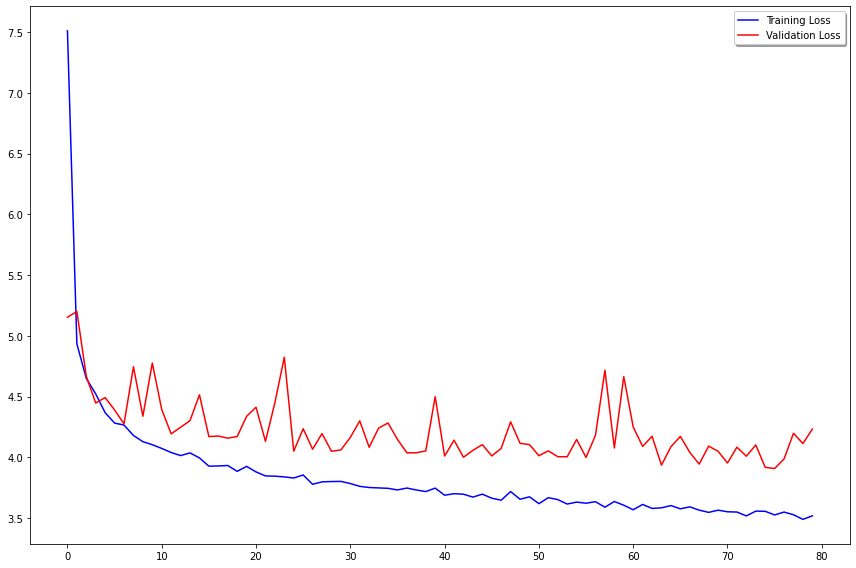

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(history.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 7.5. Con el paso de las épocas, este valor disminuye y al final del entrenamiento se sitúa en torno a 3.5.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 5.5. A lo largo del entrenamiento, este valor se va reduciendo y durante las últimas épocas vemos que se sitúa en torno a 4.5. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 76, con un valor de pérdidas de 3.91.

In [ ]:
# Convertimos el diccionario history.history en dataframe  
hist_df = pd.DataFrame(history.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.2.2 VGG16: entrenamiento fase 2.


Empezamos importando el modelo guardado en la fase anterior:

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch76-loss3.91.hdf5")

Seguimos entrenando el modelo durante 80 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 80, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/80
1144/1144 [==============================] - ETA: 0s - loss: 3.5301 - mean_absolute_error: 3.5301
Epoch 1: val_loss improved from inf to 4.11070, saving model to my_best_model.epoch01-loss4.11.hdf5
1144/1144 [==============================] - 157s 129ms/step - loss: 3.5301 - mean_absolute_error: 3.5301 - val_loss: 4.1107 - val_mean_absolute_error: 4.1107 - lr: 0.0010
Epoch 2/80
1144/1144 [==============================] - ETA: 0s - loss: 3.5245 - mean_absolute_error: 3.5245
Epoch 2: val_loss improved from 4.11070 to 3.96460, saving model to my_best_model.epoch02-loss3.96.hdf5
1144/1144 [==============================] - 153s 133ms/step - loss: 3.5245 - mean_absolute_error: 3.5245 - val_loss: 3.9646 - val_mean_absolute_error: 3.9646 - lr: 0.0010
Epoch 3/80
1144/1144 [==============================] - ETA: 0s - loss: 3.5096 - mean_absolute_error: 3.5096
Epoch 3: val_loss improved from 3.96460 to 3.93327, saving model to my_best_model.epoch03-loss3.93.hdf5
1144/1144 [==========

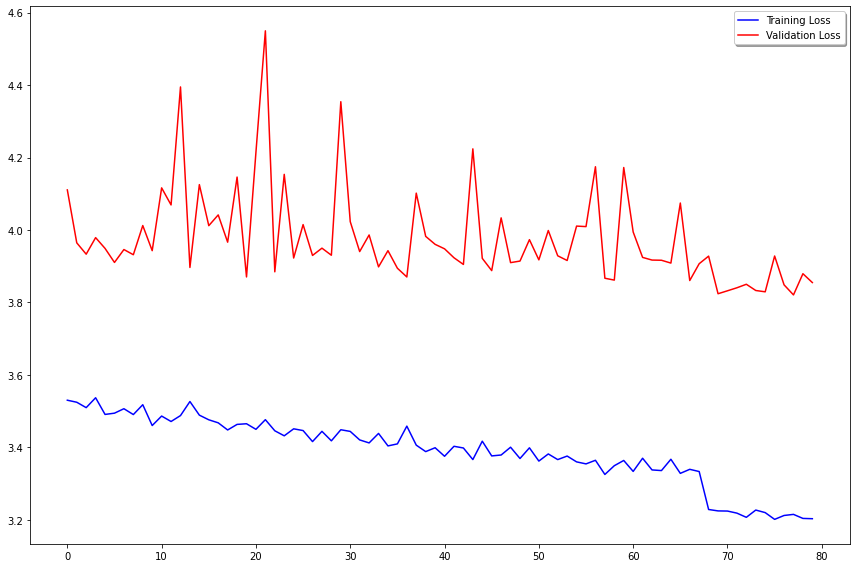

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(history.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 3.5. Con el paso de las épocas, este valor disminuye y al final del entrenamiento se sitúa en torno a 3.2.

Durante la fase de validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 4.2. A lo largo del entrenamiento, este valor se va reduciendo y durante las últimas épocas vemos que se sitúa en torno a 3.9. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 78, con un valor de pérdidas de 3.82.

In [ ]:
# Convertimos el diccionario history.history en dataframe  
hist_df = pd.DataFrame(history.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.2.3 VGG16: entrenamiento fase 3.

Empezamos importando el modelo guardado en la fase anterior:

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch78-loss3.82.hdf5")

Seguimos entrenando el modelo durante 80 épocas más. Las métricas de evaluación, función de pérdidas y método de callback no hace falta volverlos a definir, puesto que se usarán los mismos que se usaron en la fase anterior.

In [ ]:
history = model.fit(train_images, batch_size = BATCH_SIZE ,epochs = 80, shuffle=True, callbacks = callbacks, validation_data=val_images)

Epoch 1/80
1144/1144 [==============================] - ETA: 0s - loss: 3.1923 - mean_absolute_error: 3.1923
Epoch 1: val_loss improved from inf to 3.83909, saving model to my_best_model.epoch01-loss3.84.hdf5
1144/1144 [==============================] - 161s 132ms/step - loss: 3.1923 - mean_absolute_error: 3.1923 - val_loss: 3.8391 - val_mean_absolute_error: 3.8391 - lr: 5.0000e-04
Epoch 2/80
1144/1144 [==============================] - ETA: 0s - loss: 3.2118 - mean_absolute_error: 3.2118
Epoch 2: val_loss improved from 3.83909 to 3.81735, saving model to my_best_model.epoch02-loss3.82.hdf5
1144/1144 [==============================] - 153s 134ms/step - loss: 3.2118 - mean_absolute_error: 3.2118 - val_loss: 3.8173 - val_mean_absolute_error: 3.8173 - lr: 5.0000e-04
Epoch 3/80
1144/1144 [==============================] - ETA: 0s - loss: 3.1919 - mean_absolute_error: 3.1919
Epoch 3: val_loss did not improve from 3.81735
1144/1144 [==============================] - 153s 134ms/step - loss: 3

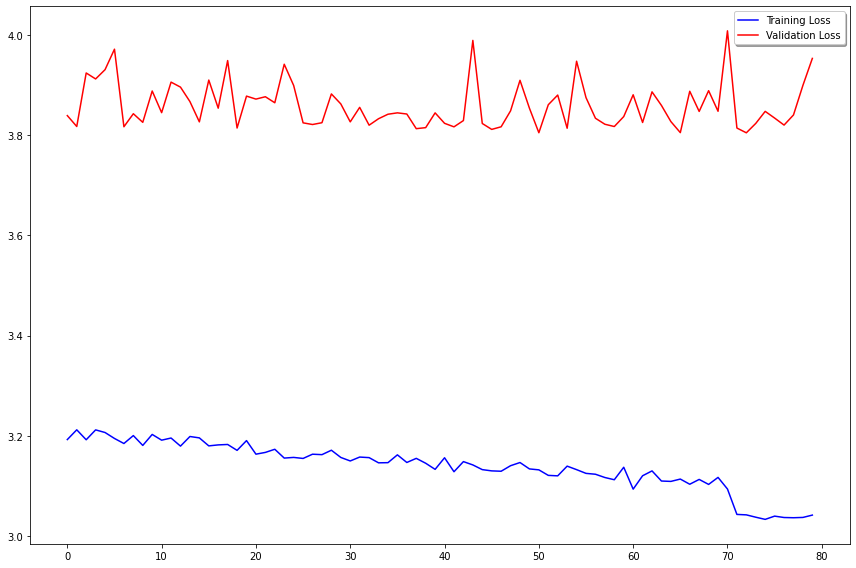

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(history.history['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(history.history['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Podemos ver que durante la fase de entrenamiento, el modelo empieza con un valor de pérdidas que se sitúa en torno a 3.2. Con el paso de las épocas, este valor disminuye y al final del entrenamiento se sitúa en torno a 3.

Durante la validación, el modelo empieza con un valor de pérdidas que se sitúa en torno a 3.9. A lo largo del entrenamiento, este valor oscila entre 3.8 y 4.2. En esta fase de entrenamiento, el mejor modelo se consiguió en la época 73, con un valor de pérdidas de 3.8.

Observando tanto la curva de pérdidas en entrenamiento como en validación, se aprecia que el modelo apenas mejora con respecto a la fase anterior, por lo que dejaremos de entrenarlo.



In [ ]:
# Convertimos el diccionario history.history en dataframe  
hist_df = pd.DataFrame(history.history) 

# y lo guardamos en un fichero CSV
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### 4.1.4 VGG16: análisis de resultados.

Una vez acabado el entrenamiento del primer modelo, vamos a graficar los resultados obtenidos durante las 240 épocas que ha durado el entrenamiento.


Importamos los CSV guardados:

In [ ]:
history1 = pd.read_csv("/content/drive/MyDrive/TFM/history1.csv")
history2 = pd.read_csv("/content/drive/MyDrive/TFM/history2.csv")
history3 = pd.read_csv("/content/drive/MyDrive/TFM/history3.csv")

Agrupamos los resultados en un único dataframe:

In [ ]:
final_dataframe = pd.concat([history1, history2, history3]).reset_index(drop=True) 

Y graficamos los valores de pérdidas:

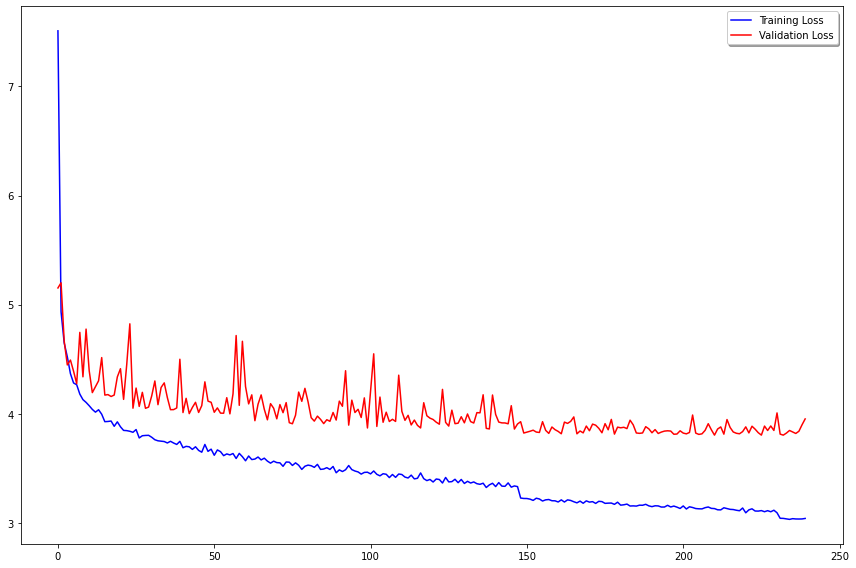

In [ ]:
# Definimos una gráfica de tamaño 12x8
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Graficamos el valor de pérdidas tanto en validación como en entrenamiento
ax1.plot(final_dataframe['mean_absolute_error'], color='b', label="Training Loss")
ax1.plot(final_dataframe['val_mean_absolute_error'], color='r',label="Validation Loss")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Observando la curva de pérdidas durante la etapa de entrenamiento y validación, vemos que a lo largo de las distintas épocas el valor de pérdida va disminuyendo progresivamente. Al final de la etapa de validación, vemos que el valor de pérdidas se sitúa en torno a 3.8, mientras que el valor de pérdidas en en entrenamiento acaba en torno a 3.1.
También, observamos que el valor de pérdidas en validación y entrenamiento parec ir estabilizándose con el paso de las épocas, por lo que todo parece indicar que este modelo tiene mejor comportamiento que el modelo CNN propuesto.


Vamos a pasar a evaluar el modelo y a hacer predicciones sobre los datos de test. Para ello, importamos el modelo que menor valor de pérdias ha conseguido. Recordemos que el mejor modelo se consiguió en la fase 3 de entrenamiento, con un valor de pérdidas en validación de 3.8.


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/TFM/my_best_model.epoch73-loss3.80.hdf5")

Evaluamos:

In [ ]:
model.evaluate(test_images)

4576/4576 [==============================] - 49s 9ms/step - loss: 3.7547 - mean_absolute_error: 3.7547


[3.7547240257263184, 3.7547240257263184]

Hacemos predicciones:

In [ ]:
predictions = model.predict(test_images)

4576/4576 [==============================] - 35s 8ms/step


Las guardamos en un dataframe:

In [ ]:
df_predictions = pd.DataFrame(data = predictions, columns = ['Predictions'])

Y graficamos 15 imágenes aleatorias junto con los valores de pérdida de potencia predichos y los valores de pérdida de potencia reales:

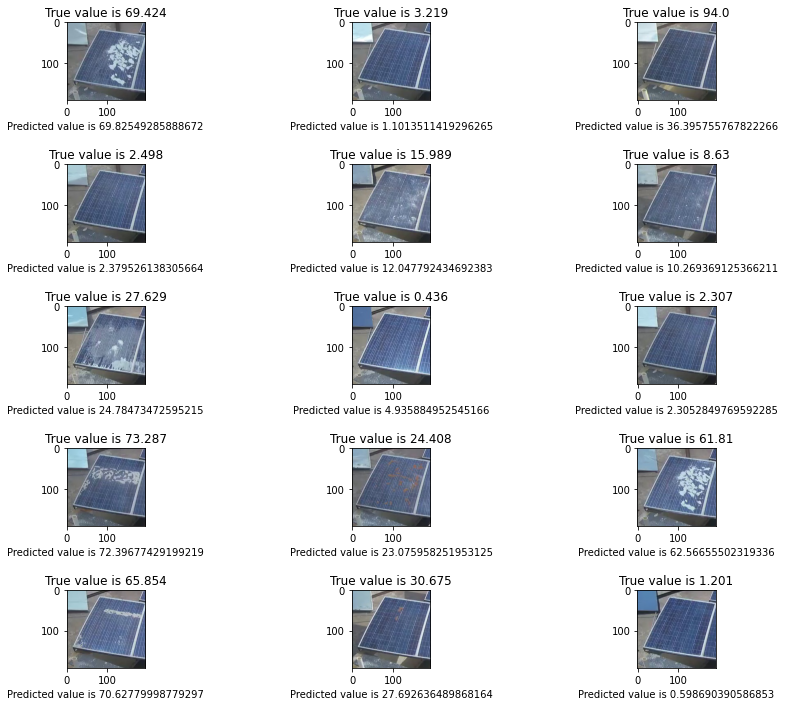

In [ ]:
# Número de filas
num_rows = 5

# Número de columnas
num_cols = 3

len(df_test_estratificado)

num_images = num_rows*num_cols
# Definimos el tamaño de la figura en función del número de columnas y filas
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):

  # Creamos la ventana de graficación
  plt.subplot(num_rows, 2*num_cols, 2*i+1)

  # Elegimos una imagen aleatoria
  sample = random.choice(range(len(df_test_estratificado)))
  
  # Graficamos la imagen elegida
  image = plt.imread('/content/output/test/PanelImages/' + df_test_estratificado['Image Name'][sample])
  plt.imshow(image, cmap=plt.cm.binary)

  # Añadimos el valor real y la predicción de pérdida de potencia
  plt.title('True value is {}'.format(df_test_estratificado['Power Loss'][sample]))
  plt.xlabel('Predicted value is {}'.format(df_predictions['Predictions'][sample]))

plt.tight_layout()
plt.show()

Analizando las predicciones vemos que, para gran parte de las imágenes, el valor predicho es cercano al valor real. Solo encontramos algunos casos en los que el valor predicho se aleja en gran medida del valor real, por lo que podemos concluir afirmando que este modelo consigue mejores resultados en el conjunto de datos de test.

Por último, vamos a comprobar como se comporta el modelo con imágenes de paneles solares diferentes a las usadas hasta ahora.

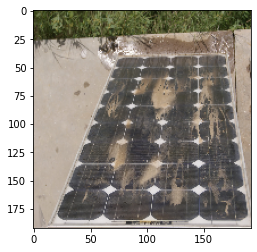

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/1.jpg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 147ms/step


array([[51.40839]], dtype=float32)

Vemos que la red da una predicción de pérdida de potencia del 51.4%. Desconocemos el valor real de pérdida de potencia de este panel de la imagen, por lo que no podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.

Comprobamos con otra imagen.


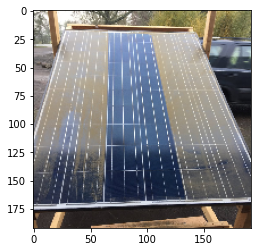

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/2.jpeg')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 17ms/step


array([[75.80139]], dtype=float32)

Nuevamente, desconocemos el valor real de pérdida de potencia de este panel de la imagen. Vemos que la red da una predicción de pérdida de potencia del 75.8%.No podemos saber si el valor de predicción que nos ha dado nuestro se aleja de la realidad. Aun así, vemos que la red da un valor coherente, puesto que en la imagen se aprecia suciedad, lo que provocaría una pérdida de potencia.


Por último, vamos a introducir una imagen de un panel que, aparentemente, no deberia presentar pérdida de potencia debido a suciedad presente en el panel.

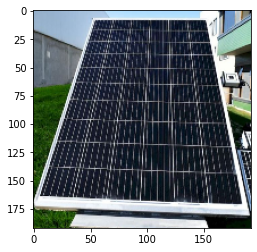

In [ ]:
# Leemos la imagen
img = cv2.imread('/content/3.JPG')

# Convertimos la imagen a RGB ya que por defecto CV2 lee en formato BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamos al tamaño de imagen que la red necesita
dsize = (192, 192)
output = cv2.resize(RGB_img, dsize)

# Normalizamos la imagen para que los coeficientes RGB estén en el rango [0,1]
norm_image = cv2.normalize(output, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Graficamos la imagen
plt.imshow(norm_image)

In [ ]:
# Añadimos la dimensión perteneciente al Batch ya que hay que respetar el formato que espera la red
img = np.expand_dims(norm_image, axis=0)

# Hacemos la predicción
model.predict(img)

1/1 [==============================] - 0s 18ms/step


array([[38.486256]], dtype=float32)

Vemos que la red da una predicción de pérdida de potencia del 38.48%. Aunque desconocemos el valor real de pérdida de potencia, no parece que este panel deba tener un valor alto. Por lo tanto, en este caso, todo parece indicar que la red está dando un valor de pérdida de potencia erróneo.